In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import glob

In [2]:
# Merge data into a single file,
directory = 'Sales_Data/*' 
dfs = [pd.read_csv(filename) for filename in glob.glob(directory)]
df = pd.concat(dfs, sort=True)
df.to_csv('sales_data.csv', index=False)

In [3]:
# Read new single file data
df = pd.read_csv('sales_data.csv')
df.head()

,Order Date,Order ID,Price Each,Product,Purchase Address,Quantity Ordered
0,04/19/19 08:46,176558,11.95,USB-C Charging Cable,"917 1st St, Dallas, TX 75001",2
1,NaN,NaN,NaN,NaN,NaN,NaN
2,04/07/19 22:30,176559,99.99,Bose SoundSport Headphones,"682 Chestnut St, Boston, MA 02215",1
3,04/12/19 14:38,176560,600,Google Phone,"669 Spruce St, Los Angeles, CA 90001",1
4,04/12/19 14:38,176560,11.99,Wired Headphones,"669 Spruce St, Los Angeles, CA 90001",1


In [4]:
# Drop NA rows
df.dropna(inplace=True)

# Remove column names as rows
df = df[df['Order ID'] != 'Order ID']

In [5]:
# Separate last column into columns: 'Address', 'State', 'City'
addresses = np.array([address.split(', ') for address in df['Purchase Address'].values])

# Assign to new columns
df['City'] = addresses[:, 1]
df['State'] = [x[:2] for x in addresses[:, 2]]

# Drop old columns Purchase Address and Street
df.drop(['Purchase Address'], axis='columns', inplace=True)

# Add total price column
df['Order Price'] = pd.to_numeric(df['Quantity Ordered']) * pd.to_numeric(df['Price Each'])

In [6]:
df.head()

,Order Date,Order ID,Price Each,Product,Quantity Ordered,City,State,Order Price
0,04/19/19 08:46,176558,11.95,USB-C Charging Cable,2,Dallas,TX,23.90
2,04/07/19 22:30,176559,99.99,Bose SoundSport Headphones,1,Boston,MA,99.99
3,04/12/19 14:38,176560,600,Google Phone,1,Los Angeles,CA,600.00
4,04/12/19 14:38,176560,11.99,Wired Headphones,1,Los Angeles,CA,11.99
5,04/30/19 09:27,176561,11.99,Wired Headphones,1,Los Angeles,CA,11.99


In [7]:
# Change column dtypes int and float
dtypes = ['object', 'object', 'float', 'object', 'int', 'category', 'category', 'float']
col_types = dict(zip(df.columns, dtypes))
df = df.astype(col_types)

# Change Order Date dtype to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [8]:
# Column data types and DataFrame Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 0 to 186849
Data columns (total 8 columns):
Order Date          185950 non-null datetime64[ns]
Order ID            185950 non-null object
Price Each          185950 non-null float64
Product             185950 non-null object
Quantity Ordered    185950 non-null int64
City                185950 non-null category
State               185950 non-null category
Order Price         185950 non-null float64
dtypes: category(2), datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 10.3+ MB


In [9]:
# Display first 10 rows of DataFrame
df.head(10)

,Order Date,Order ID,Price Each,Product,Quantity Ordered,City,State,Order Price
0,2019-04-19 08:46:00,176558,11.95,USB-C Charging Cable,2,Dallas,TX,23.90
2,2019-04-07 22:30:00,176559,99.99,Bose SoundSport Headphones,1,Boston,MA,99.99
3,2019-04-12 14:38:00,176560,600.00,Google Phone,1,Los Angeles,CA,600.00
4,2019-04-12 14:38:00,176560,11.99,Wired Headphones,1,Los Angeles,CA,11.99
5,2019-04-30 09:27:00,176561,11.99,Wired Headphones,1,Los Angeles,CA,11.99
6,2019-04-29 13:03:00,176562,11.95,USB-C Charging Cable,1,San Francisco,CA,11.95
7,2019-04-02 07:46:00,176563,99.99,Bose SoundSport Headphones,1,Seattle,WA,99.99
8,2019-04-12 10:58:00,176564,11.95,USB-C Charging Cable,1,Atlanta,GA,11.95
9,2019-04-24 10:38:00,176565,1700.00,Macbook Pro Laptop,1,San Francisco,CA,1700.00
10,2019-04-08 14:05:00,176566,11.99,Wired Headphones,1,Boston,MA,11.99


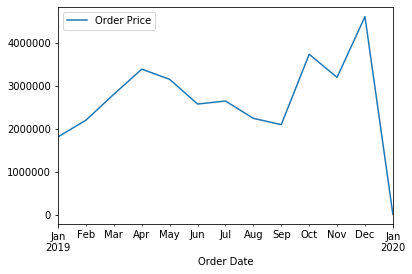

In [10]:
# What was the best month for sales?
sales_per_month = df.set_index('Order Date')
sales_per_month = sales_per_month[['Order Price']].resample('M').sum()
sales_per_month.plot()
plt.show()

# Answer:
# December was the best month for sales.

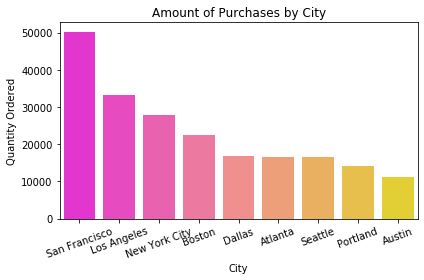

In [11]:
# Which city sold the most products?
city_count = df.groupby('City').sum()
city_count.sort_values('Quantity Ordered', ascending=False, inplace=True)
city_count.reset_index(inplace=True)
sns.barplot(x='City', y='Quantity Ordered', data=city_count, order=city_count['City'], palette='spring')
plt.xticks(rotation=20)
plt.title('Amount of Purchases by City')
plt.tight_layout()
plt.show()

# Answer
# San Francisco sells the most products.


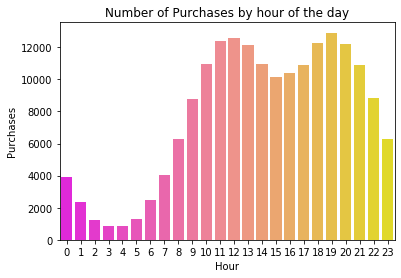

In [12]:
# What time should we display advertisements to maximize the likelihood of purchases?
times = pd.to_datetime(df['Order Date'])
times = pd.DataFrame(times.groupby(times.dt.hour).count())
times.index.name, times.columns = 'Hour', ['Purchases']
sns.barplot(x=times.index, y=times['Purchases'], palette='spring')
plt.title('Number of Purchases by hour of the day')
plt.show()

# Answer:
# Data suggests most purchases occur at 12:00 and 19:00 hours. 

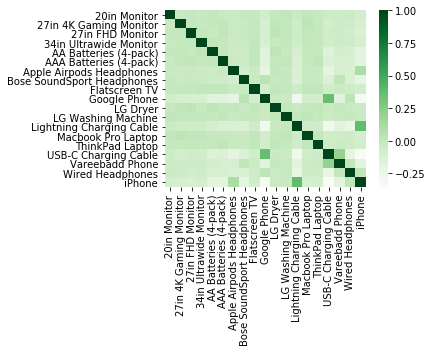

In [13]:
# What products are most often sold together?
sold_together = df[['Order ID', 'Product']]
dummified = pd.get_dummies(sold_together, columns=sold_together.columns[1:], prefix='', prefix_sep='').reset_index(drop=True)
sold_together = dummified.groupby('Order ID').sum()
sold_together = sold_together[sold_together.sum(axis='columns') > 1]

# Figure configuration HeatMap
fig, ax = plt.subplots(figsize=(6, 5))
sales_corr = sold_together.corr()
vmin, vmax = np.min(sales_corr.values), np.max(sales_corr.values)
sns.heatmap(sales_corr, cmap='Greens', vmin=vmin, vmax=vmax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.tight_layout()

# Answer
# (Google Phone + USB-C Charging Cables + Wireless Headphones) & (iPhone + Lightning Charging Cable + Apple Airpods)


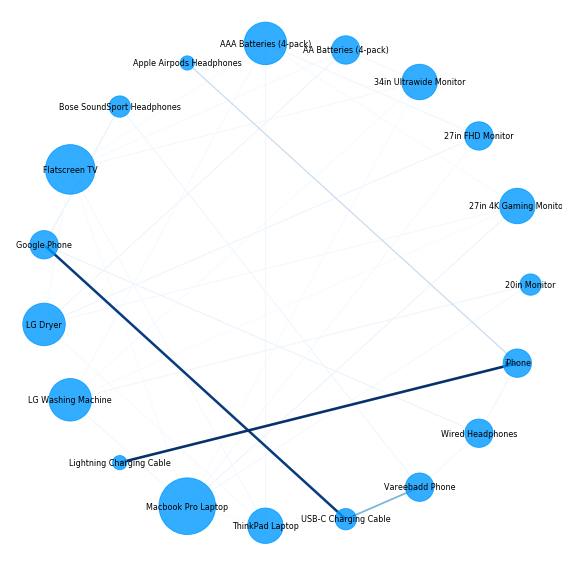

0

In [14]:
# What products are sold the most using graphs with NetworkX?

# Fill diagonal with 0 and create adjacency matrix
np.fill_diagonal(sales_corr.values, 0)
sales_matrix = np.asmatrix(sales_corr)

# Get metadata of each node
products = sales_corr.columns
prices = df.groupby('Product')['Price Each'].mean()

# Instanciate graph and label nodes
G = nx.from_numpy_matrix(sales_matrix)
G = nx.relabel_nodes(G, lambda x: products[x])

# Import plotting script and plot graph
from graph_plot import plot_corr_network

# Plot sales correlation Graph
plot_corr_network(G, corr_tresh=0, scaling=50)

# Answer:
# Expanding on the previous analysis Apple Airpods Headphones are frequenctly bought with
# iPhones and Lightning Charging Cables.